In [3]:
%load_ext autoreload

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
from sklearn.linear_model import LinearRegression

In [8]:
%autoreload 2
from src.data.make_dataset import make_cat_dict,calc_reactor_metrics

In [9]:
raw_dir = "C:/Users/Hermans_Desktop1/OneDrive - UW-Madison/Documents/Research/2022-P4 (Pt DH ML)/iterative_catalyst_design/data/raw"

# 1) Exploring 1-Cycle Yield

The first metric we will explore is the concept of 1-Cycle Yield. If we assume first-order deactivation in our catalyst we can model our yield ($Y$) as:
$$ Y(t) = Y_0e^{-k_dt}$$
where $Y_0$ represents the initial yield and $k_d$ is the deactivation coefficient. Next, we can create a 1-Cycle yield metric ($Y_{1C}$) as:

$$Y_{1C}=\int ^\infty_0 Y_0e^{-k_dt}dt=\frac{Y_0}{-k_d}$$

Let's assess the performance of this metric.

In [18]:
#load in reactor data
fname = "Runs to Analyze Notebook 1.txt"
catalysts = make_cat_dict(raw_dir+"/"+fname,raw_data_path=raw_dir)

#remove all entries that don't correspond to Pt1Sn4Ca4 tested under identical conditions


for cat in catalysts[::-1]: #traverse list backwards to avoid indexing issues
    if cat["Reaction"] != "24-006" and  cat["Tube"] != 1:
        catalysts.remove(cat)

for cat in catalysts:
    print(f'Name: {cat["Catalyst"]} Rxn: {cat["Reaction"]} Tube: {cat["Tube"]}')

Loading in reaction 006
Loading in reaction 007
Loading in reaction 008
Name: Pt1Sn4Ca4/Al2O3 Rxn: 24-006 Tube: 1
Name: Pt1Sn4Ca4/Al2O3 Rxn: 24-006 Tube: 2
Name: Pt1Sn4Ca4/Al2O3 Rxn: 24-006 Tube: 3
Name: Pt1Sn4Ca4/Al2O3 Rxn: 24-006 Tube: 4
Name: Pt1Sn4Ca4/Al2O3 Rxn: 24-006 Tube: 5
Name: Pt1Sn4Ca4/Al2O3 Rxn: 24-006 Tube: 6
Name: Pt1Sn4Ca4/Al2O3 wTC Rxn: 24-007 Tube: 1
Name: Pt1Sn4Ca4/Al2O3 (1.4) Rxn: 24-008 Tube: 1


## 1a Spread in experimental data

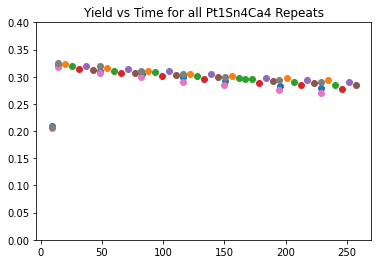

In [31]:
#observe variance in data
for i, cat in enumerate(catalysts):
    t = np.asarray(cat["Time Since Start"])
    Y_expt = np.asarray(cat["Conversion"])*np.asarray(cat["Selectivity"])
    plt.plot(t,Y_expt,'o',label=i)
plt.title("Yield vs Time for all Pt1Sn4Ca4 Repeats")
plt.ylim((0,.4))
plt.show()

## 1b Quality of exponential decay model fit

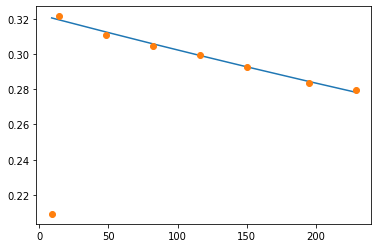

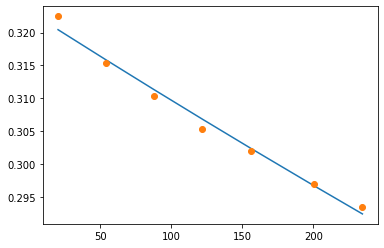

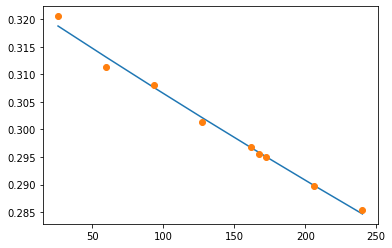

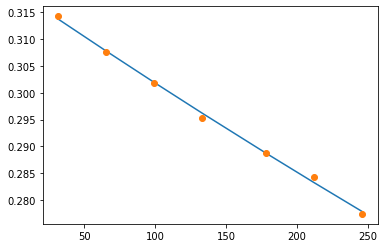

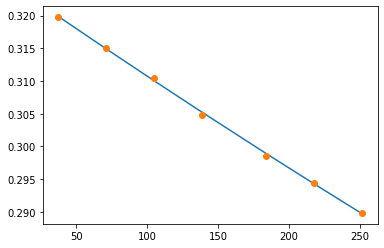

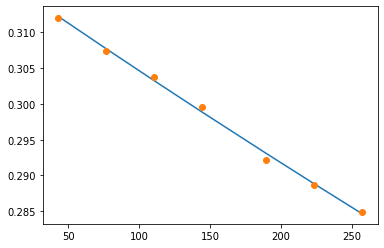

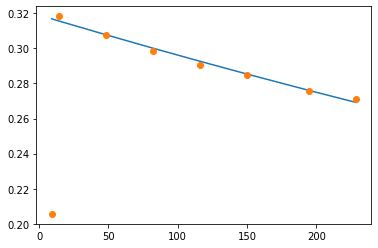

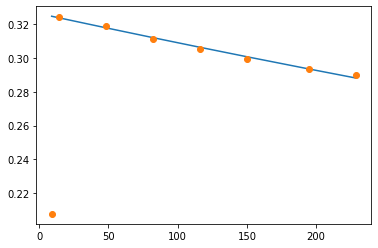

In [22]:
#create linear regression fits
fits = []
for cat in catalysts:
    fit = calc_reactor_metrics(cat) #ignores data with worse than 100 +/- 5% CB
    fits.append(fit)
    t = np.asarray(cat["Time Since Start"])
    Y_expt = np.asarray(cat["Conversion"])*np.asarray(cat["Selectivity"])
    plt.plot(t,fit[1]*np.exp(-fit[0]*t))
    plt.plot(t,Y_expt,"o")
    plt.show()
    

## 1c Spread in $Y_0$, $k_d$, $Y_{1C}$

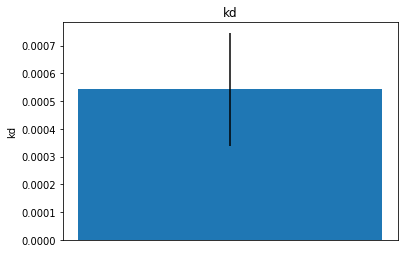

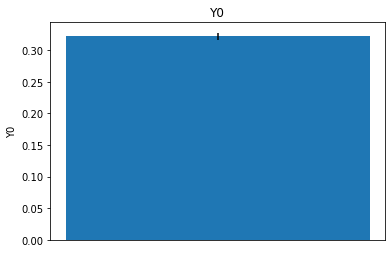

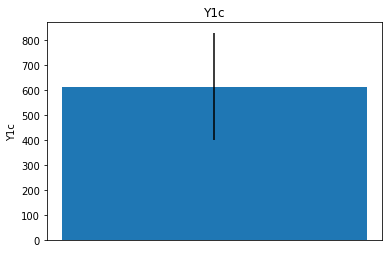

In [36]:


for i, label in enumerate(["kd","Y0","Y1c"]):
    arr = np.asarray([fit[i] for fit in fits])
    plt.bar([0.5],np.average(arr),yerr=2*np.std(arr))
    plt.xticks([], [])
    plt.ylabel(label)
    plt.title(label)
    plt.show()


*$k_d$ has too much noise. It will cause issues when attempting to predict performance.*

# 2) Partial-Cycle Yield ($Y_{t1-t2}$)

Instead, let's do an integral over part of the time:

$$Y_{t1-t2}=\int^{t_2}_{t1} Y_0e^{-k_dt}dt=\frac{Y_0}{k_d}(e^{-k_dt_1}-e^{-k_dt_2})$$

Let's assess the fit for various t1,t2.

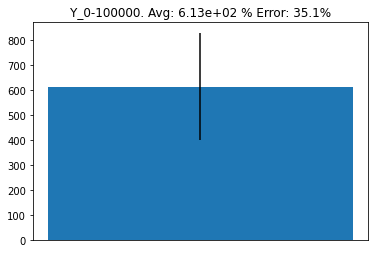

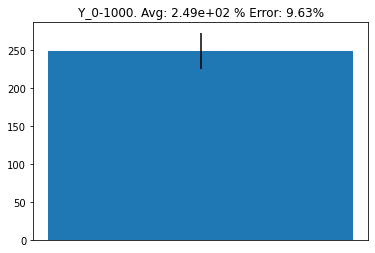

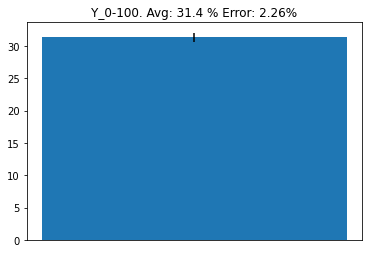

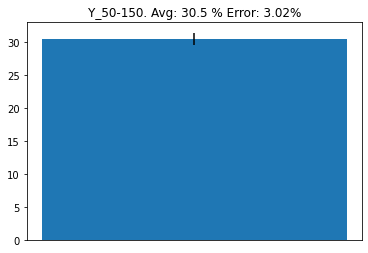

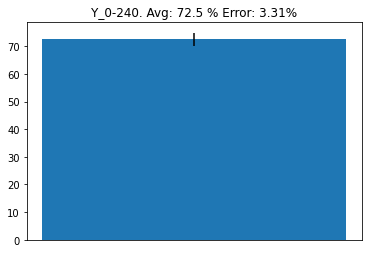

In [47]:
for t1,t2 in [(0,100000),(0,1000),(0,100),(50,150),(0,240)]:
    arr = np.asarray([fit[1]/fit[0]*(np.exp(-fit[0]*t1)-np.exp(-fit[0]*t2)) for fit in fits])
    avg = np.average(arr)
    err = 2*np.std(arr)
    plt.bar([0.5],avg,yerr=err)
    plt.xticks([], [])
    plt.title(f'Y_{t1}-{t2}. Avg: {avg:.3} % Error: {100*err/avg:.3}%')
    plt.savefig(f'./figures/Y_{t1}-{t2}.png',dpi=600)
    plt.show()

*We will use $t_1=0$, $t_2=240$ because it has much less error while still being a significant quantity of data. It also fits our range of data collection quite closely.*